In [1]:
import numpy as np
import pandas as pd
from dfply import *
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import timedelta
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')

# 데이터 정제 시 필요한 모듈들
import src.subjectlist_alignment.pairing as pairing   # 삽관 발관 페어링 관련 모듈
from src.subjectlist_alignment import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src.subjectlist_alignment import imputation as imp   # 결측치 대체 관련 모듈
from src.subjectlist_alignment import subject_classification as cls

import src.utils.utils as utils   # 기타 유틸리티 모듈
import src.data_extraction.access_database as db   # DB 연결 관련 모듈

In [2]:
# 변수를 붙일 subjectlist 데이터 가져오기

data_dir = '../outputs/subjectlist1.csv'
subjectlist1 = pd.read_csv(data_dir, index_col=0)
age = pd.read_csv('../outputs/age.csv')


# datetime 변환
time_cols = ['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime', 'reintubation_eventtime']
subjectlist1 = utils.to_datetime(subjectlist1, time_cols)
print(subjectlist1.shape)

# 데이터 단순화
cols = ['subject_id', 'hadm_id', 'stay_id', 'admittime', 'dischtime', 'deathtime', 'class']
# unique_hadms = list(subjectlist1.hadm_id.unique())
trimmed_table = subjectlist1[cols]

# age 와 결합
sl = pd.merge(trimmed_table, age[['subject_id', 'hadm_id', 'age']], on=['subject_id', 'hadm_id'], how='left')

sl['age'] = pd.to_numeric(sl['age'], errors='coerce')
sl['age'] = sl['age'].round(2)
sl.rename(columns={'age': 'age_original'}, inplace=True)   # 이름 변경. 비교 위함.

sl

Converted admittime to datetime.
Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
Converted reintubation_eventtime to datetime.
(9003, 29)


,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age_original
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,nonfailure,75.59
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-13 17:31:00,NaT,nonfailure,85.27
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,failure,85.06
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,nonfailure,85.06
...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30
8999,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30
9000,19999068,21606769,30143796,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,nonfailure,63.64
9001,19999442,26785317,32336619,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,nonfailure,43.88


age 결합

### oasis

In [3]:
oasis = pd.read_csv('../outputs/oasis.csv')
oasis

,subject_id,hadm_id,stay_id,oasis,oasis_prob,age,age_score,preiculos,preiculos_score,gcs,...,resprate,resp_rate_score,temp,temp_score,urineoutput,urineoutput_score,mechvent,mechvent_score,electivesurgery,electivesurgery_score
0,15726063,23069026,36415879,36,0.170145,53.383987,6,73.000000,3,15.0,...,31.0,6.0,38.560,2.0,4580.0,0.0,1,9,0,6
1,14304873,20156152,35621403,28,0.068843,75.150576,6,9241.966667,1,14.0,...,32.0,6.0,35.400,4.0,2390.0,1.0,0,0,0,6
2,12117555,25128945,37212487,34,0.137099,82.377898,9,14055.783333,1,9.0,...,27.0,1.0,36.615,0.0,85.0,10.0,0,0,0,6
3,16645325,26608451,37532286,33,0.122701,77.625816,9,1691.983333,1,15.0,...,24.0,1.0,38.000,2.0,1015.0,5.0,0,0,0,6
4,10989579,26999802,38267080,26,0.054187,25.871665,3,95.000000,3,15.0,...,34.0,6.0,36.390,2.0,1225.0,5.0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73176,16312808,28382354,37548942,13,0.010803,39.943556,3,1130.916667,0,15.0,...,24.0,1.0,39.610,2.0,3575.0,0.0,0,0,0,6
73177,14472165,20369424,38998125,33,0.122701,57.950882,6,4255.233333,1,14.0,...,44.0,6.0,36.220,2.0,2670.0,0.0,0,0,0,6
73178,19603646,24079072,35813245,28,0.068843,47.621032,3,5557.183333,1,15.0,...,26.0,1.0,36.390,2.0,1125.0,5.0,1,9,0,6
73179,16915170,20987661,38612688,20,0.025967,47.843902,3,23.000000,3,13.0,...,17.5,0.0,36.940,2.0,1500.0,1.0,0,0,0,6


In [4]:
oasis.stay_id.nunique()

73181

In [5]:
oasis.columns   # 'oasis', 'oasis_prob'

Index(['subject_id', 'hadm_id', 'stay_id', 'oasis', 'oasis_prob', 'age',
       'age_score', 'preiculos', 'preiculos_score', 'gcs', 'gcs_score',
       'heartrate', 'heart_rate_score', 'meanbp', 'mbp_score', 'resprate',
       'resp_rate_score', 'temp', 'temp_score', 'urineoutput',
       'urineoutput_score', 'mechvent', 'mechvent_score', 'electivesurgery',
       'electivesurgery_score'],
      dtype='object')

In [6]:
# 중복값?
oasis_duplicates = oasis.duplicated(subset=['stay_id'], keep=False)
oasis_duplicate_count = oasis_duplicates.sum()
oasis_duplicate_count

0

In [7]:
# 테이블 머지
sl2 = pd.merge(sl, oasis[['subject_id', 'hadm_id', 'stay_id', 'oasis', 'oasis_prob', 'age', 'age_score']], on=['subject_id', 'hadm_id', 'stay_id'], how='left')
sl2

,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age_original,oasis,oasis_prob,age,age_score
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02,34,0.137099,77.018296,9
1,10003400,23559586,38383343,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,nonfailure,75.59,60,0.813877,75.589414,6
2,10004401,27939719,31202136,2144-04-11 03:31:00,2144-04-13 17:31:00,NaT,nonfailure,85.27,53,0.641734,85.274942,9
3,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,failure,85.06,46,0.423212,85.059155,9
4,10004401,29988601,32773003,2144-01-23 07:58:00,2144-02-06 11:45:00,NaT,nonfailure,85.06,46,0.423212,85.059155,9
...,...,...,...,...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30,43,0.333566,63.299259,6
8999,19997367,20617667,35616526,2126-04-20 07:15:00,2126-05-19 14:15:00,NaT,nonfailure,63.30,43,0.333566,63.299259,6
9000,19999068,21606769,30143796,2161-08-24 04:10:00,2161-09-02 19:00:00,NaT,nonfailure,63.64,46,0.423212,63.643884,6
9001,19999442,26785317,32336619,2148-11-19 10:00:00,2148-12-04 16:25:00,NaT,nonfailure,43.88,25,0.048012,43.884161,3


In [8]:
sl2.age_score.unique()

array([9, 6, 3, 0, 7])

In [9]:
# age score 잘 들어갔는지 확인

def check_age_logic(row):
    if pd.isnull(row['age']):
        expected_score = None
    elif row['age'] < 24:
        expected_score = 0
    elif row['age'] <= 53:
        expected_score = 3
    elif row['age'] <= 77:
        expected_score = 6
    elif row['age'] <= 89:
        expected_score = 9
    elif row['age'] >= 90:
        expected_score = 7
    else:
        expected_score = 0  # Default case, should not be reached due to above conditions
    
    # Check if the expected score matches the actual score in the DataFrame
    if row['age_score'] != expected_score:
        print(f"Inconsistency found: Age={row['age']}, Actual Score={row['age_score']}, Expected Score={expected_score}")

# Apply the function to each row in the DataFrame and check for inconsistencies
age_logic_test = sl2.apply(check_age_logic, axis=1)

age는 문제 없는 듯.

In [10]:
oasis_mean = sl2.oasis.mean()
oasis_median = sl2.oasis.median()
oasis_std = sl2.oasis.std()
oasis_min = sl2.oasis.min()
oasis_max = sl2.oasis.max()

print('oasis')
print(f'oasis_mean: {oasis_mean}')
print(f'oasis_median: {oasis_median}')
print(f'oasis_std: {oasis_std}')
print(f'oasis_range: {oasis_min} - {oasis_max}')

oasis
oasis_mean: 37.521492835721425
oasis_median: 37.0
oasis_std: 8.323594487198648
oasis_range: 6 - 68


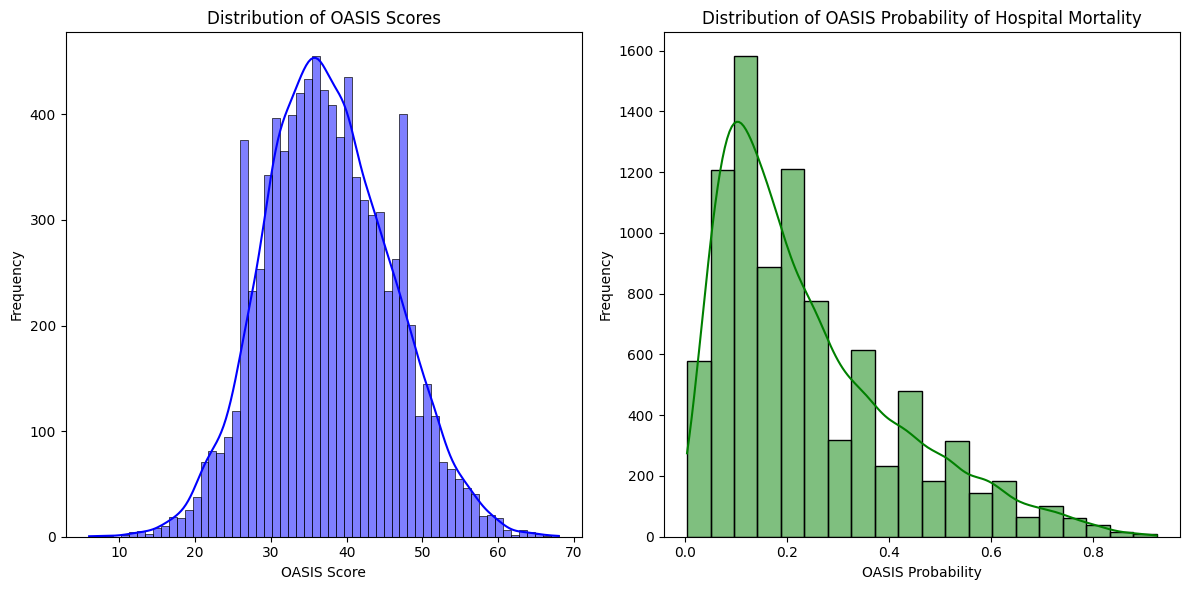

In [11]:
# Visualize the distribution of 'apsiii'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First subplot in a 1x2 grid
sns.histplot(sl2['oasis'], kde=True, color='blue', edgecolor='black')
plt.title('Distribution of OASIS Scores')
plt.xlabel('OASIS Score')
plt.ylabel('Frequency')

# Visualize the distribution of 'apsiii_prob'
plt.subplot(1, 2, 2)  # Second subplot in a 1x2 grid
sns.histplot(sl2['oasis_prob'], kde=True, color='green', bins=20, edgecolor='black')
plt.title('Distribution of OASIS Probability of Hospital Mortality')
plt.xlabel('OASIS Probability')
plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()

### gcs
- (1) The verbal component can be set to 0 if the patient is ventilated.
    - This is corrected to 5 - the overall GCS is set to 15 in these cases.
- (2) Often only one of three components is documented. The other componentsare carried forward.

In [12]:
gcs = pd.read_csv('../outputs/gcs.csv')

# datetime 변환
time_cols = ['charttime']
gcs = utils.to_datetime(gcs, time_cols)

gcs

Converted charttime to datetime.


,subject_id,stay_id,charttime,gcs,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable
0,12466550,30000153,2174-09-29 12:45:00,15.0,5.0,0.0,3.0,1
1,12466550,30000153,2174-09-29 16:26:00,15.0,6.0,0.0,4.0,1
2,12466550,30000153,2174-09-29 17:37:00,15.0,6.0,0.0,4.0,1
3,12466550,30000153,2174-09-29 18:00:00,9.0,5.0,1.0,3.0,0
4,12466550,30000153,2174-09-29 19:00:00,9.0,5.0,1.0,3.0,0
...,...,...,...,...,...,...,...,...
1637758,17840864,39999810,2115-12-05 00:00:00,14.0,6.0,5.0,3.0,0
1637759,17840864,39999810,2115-12-05 04:00:00,14.0,6.0,5.0,3.0,0
1637760,17840864,39999810,2115-12-05 08:28:00,15.0,6.0,5.0,4.0,0
1637761,17840864,39999810,2115-12-05 12:00:00,15.0,6.0,5.0,4.0,0


stay id 별로 여러개의 gcs 이벤트가 있음. charttime 참고할 필요

In [13]:
gcs.columns

Index(['subject_id', 'stay_id', 'charttime', 'gcs', 'gcs_motor', 'gcs_verbal',
       'gcs_eyes', 'gcs_unable'],
      dtype='object')

In [14]:
gcs.gcs_unable.unique()

array([1, 0])

In [15]:
gcs.columns

Index(['subject_id', 'stay_id', 'charttime', 'gcs', 'gcs_motor', 'gcs_verbal',
       'gcs_eyes', 'gcs_unable'],
      dtype='object')

In [16]:
# 중복값?
gcs_duplicates = gcs.duplicated(subset=['stay_id'], keep=False)
gcs_duplicate_count = gcs_duplicates.sum()
gcs_duplicate_count

1636643

In [17]:
(gcs.gcs_verbal == 0).sum()

575905

In [18]:
(gcs.gcs_unable == 1).sum()

573198

In [19]:
(gcs.gcs_unable == 0).sum()

1064565

In [20]:
# 측정시점 별 기간 계산
# Ensure 'charttime' is a datetime
gcs['charttime'] = pd.to_datetime(gcs['charttime'])

# Sort the DataFrame
gcs.sort_values(by=['stay_id', 'charttime'], inplace=True)

# Calculate the time difference within each 'stay_id' group
gcs['time_interval'] = gcs.groupby('stay_id')['charttime'].diff()

gcs

,subject_id,stay_id,charttime,gcs,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,time_interval
0,12466550,30000153,2174-09-29 12:45:00,15.0,5.0,0.0,3.0,1,NaT
1,12466550,30000153,2174-09-29 16:26:00,15.0,6.0,0.0,4.0,1,0 days 03:41:00
2,12466550,30000153,2174-09-29 17:37:00,15.0,6.0,0.0,4.0,1,0 days 01:11:00
3,12466550,30000153,2174-09-29 18:00:00,9.0,5.0,1.0,3.0,0,0 days 00:23:00
4,12466550,30000153,2174-09-29 19:00:00,9.0,5.0,1.0,3.0,0,0 days 01:00:00
...,...,...,...,...,...,...,...,...,...
1637758,17840864,39999810,2115-12-05 00:00:00,14.0,6.0,5.0,3.0,0,0 days 04:00:00
1637759,17840864,39999810,2115-12-05 04:00:00,14.0,6.0,5.0,3.0,0,0 days 04:00:00
1637760,17840864,39999810,2115-12-05 08:28:00,15.0,6.0,5.0,4.0,0,0 days 04:28:00
1637761,17840864,39999810,2115-12-05 12:00:00,15.0,6.0,5.0,4.0,0,0 days 03:32:00


In [41]:
utils.print_desc_stats(gcs, 'time_interval')

mean: 0 days 03:48:22.816136277
median: 0 days 04:00:00
std: 2 days 06:47:54.749676913
range: 0 days 00:01:00 - 2191 days 03:33:00


In [22]:
gcs.time_interval.mean()

Timedelta('0 days 03:48:22.816136277')

In [23]:
((gcs.gcs_verbal == 0) & (gcs.gcs_unable == 1)).sum()   # 호흡기 삽관으로 인해 verbal score 가 0 인 케이스 
# -> 이런 경우는 인위적으로 점수 보정이 들어감 (15로 통일 되는 듯함. 아래 코드 결과 참고)
# 이게 타당한건지?

573198

In [24]:
gcs[(gcs.gcs_verbal == 0) & (gcs.gcs_unable == 1)].gcs.unique()

array([15.])

In [25]:
# 평균적으로 환자별로 몇 번의 charttime이 있을까? (stayid, subjectid 각각 기준으로)

# Calculate the number of GCS data points per 'stay_id'
gcs_per_stay = gcs.groupby('stay_id').size()

# Calculate statistics for GCS data points per 'stay_id'
stay_avg = gcs_per_stay.mean()
stay_std = gcs_per_stay.std()
stay_range = (gcs_per_stay.min(), gcs_per_stay.max())

# Calculate the number of GCS data points per 'subject_id'
gcs_per_subject = gcs.groupby('subject_id').size()

# Calculate statistics for GCS data points per 'subject_id'
subject_avg = gcs_per_subject.mean()
subject_std = gcs_per_subject.std()
subject_range = (gcs_per_subject.min(), gcs_per_subject.max())

(stay_avg, stay_std, stay_range), (subject_avg, subject_std, subject_range)

((22.52211281938447, 34.974837265575104, (1, 779)),
 (32.23689079600032, 51.03014081427481, (1, 1191)))

In [26]:
# 테이블 머지
sl3 = pd.merge(sl2, gcs[['subject_id', 'stay_id', 'charttime', 'gcs', 'gcs_unable']], on=['subject_id', 'stay_id'], how='left')
sl3.rename(columns={'charttime':'gcs_charttime'})
sl3

,subject_id,hadm_id,stay_id,admittime,dischtime,deathtime,class,age_original,oasis,oasis_prob,age,age_score,charttime,gcs,gcs_unable
0,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02,34,0.137099,77.018296,9,2131-01-11 08:00:00,15.0,1.0
1,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02,34,0.137099,77.018296,9,2131-01-11 10:00:00,15.0,1.0
2,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02,34,0.137099,77.018296,9,2131-01-11 12:00:00,15.0,1.0
3,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02,34,0.137099,77.018296,9,2131-01-11 14:00:00,15.0,1.0
4,10001884,26184834,37510196,2131-01-07 20:39:00,2131-01-20 05:15:00,2131-01-20 05:15:00,nonfailure,77.02,34,0.137099,77.018296,9,2131-01-11 16:00:00,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572388,19999840,21033226,38978960,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,death,58.69,39,0.231102,58.694264,6,2164-09-16 20:21:00,15.0,1.0
572389,19999840,21033226,38978960,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,death,58.69,39,0.231102,58.694264,6,2164-09-17 00:00:00,15.0,1.0
572390,19999840,21033226,38978960,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,death,58.69,39,0.231102,58.694264,6,2164-09-17 04:00:00,15.0,1.0
572391,19999840,21033226,38978960,2164-09-10 13:47:00,2164-09-17 13:42:00,2164-09-17 13:42:00,death,58.69,39,0.231102,58.694264,6,2164-09-17 08:08:00,15.0,1.0


In [27]:
(sl3.gcs_unable == 1).sum()

341957

In [28]:
sl3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572393 entries, 0 to 572392
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   subject_id    572393 non-null  int64         
 1   hadm_id       572393 non-null  int64         
 2   stay_id       572393 non-null  int64         
 3   admittime     572393 non-null  datetime64[ns]
 4   dischtime     572393 non-null  datetime64[ns]
 5   deathtime     138839 non-null  datetime64[ns]
 6   class         526039 non-null  object        
 7   age_original  572393 non-null  float64       
 8   oasis         572393 non-null  int64         
 9   oasis_prob    572393 non-null  float64       
 10  age           572393 non-null  float64       
 11  age_score     572393 non-null  int64         
 12  charttime     572381 non-null  datetime64[ns]
 13  gcs           572381 non-null  float64       
 14  gcs_unable    572381 non-null  float64       
dtypes: datetime64[ns]

In [29]:
# 중복치 때문에 정확하지 않음

gcs_mean = sl3.gcs.mean()
gcs_median = sl3.gcs.median()
gcs_std = sl3.gcs.std()
gcs_min = sl3.gcs.min()
gcs_max = sl3.gcs.max()

print('gcs')
print(f'gcs_mean: {gcs_mean}')
print(f'gcs_median: {gcs_median}')
print(f'gcs_std: {gcs_std}')
print(f'gcs_range: {gcs_min} - {gcs_max}')

gcs
gcs_mean: 14.307723352102883
gcs_median: 15.0
gcs_std: 1.8236348484687286
gcs_range: 3.0 - 15.0


Text(0, 0.5, 'Frequency')

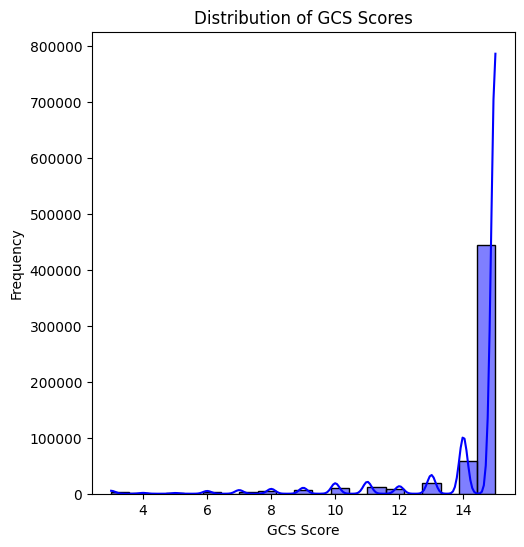

In [30]:
# 중복치 때문에 정확하지 않음
# Visualize the distribution of 'gcs' within subjects
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First subplot in a 1x2 grid
sns.histplot(sl3['gcs'], kde=True, color='blue', edgecolor='black')
plt.title('Distribution of GCS Scores')
plt.xlabel('GCS Score')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

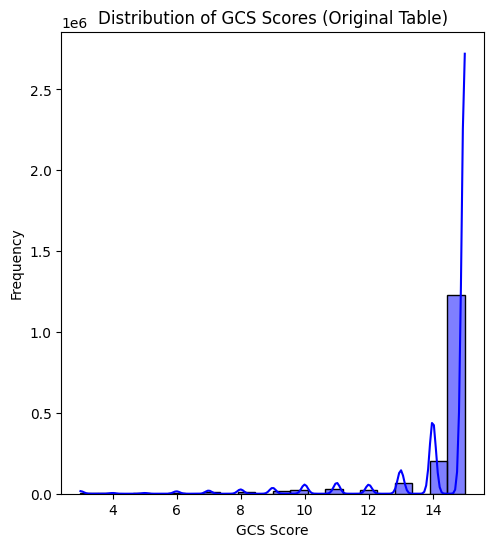

In [31]:
# Visualize the distribution of total 'gcs'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First subplot in a 1x2 grid
sns.histplot(gcs['gcs'], kde=True, color='blue', edgecolor='black')
plt.title('Distribution of GCS Scores (Original Table)')
plt.xlabel('GCS Score')
plt.ylabel('Frequency')

In [32]:
# Assuming 'gcs' DataFrame contains 'gcs' column with the GCS scores
# Create a mask for patients with GCS scores under 15
mask_under_15 = gcs['gcs'] < 15

# Create a mask for patients with GCS scores in the 15 range
mask_15 = gcs['gcs'] == 15

# Filter patients based on the masks
patients_under_15 = gcs[mask_under_15]
patients_15 = gcs[mask_15]

# Get unique subject IDs for each group
unique_subjects_under_15 = patients_under_15['subject_id'].unique()
unique_subjects_15 = patients_15['subject_id'].unique()

# Calculate the number of GCS measurements per subject for each group
gcs_measurements_under_15 = patients_under_15.groupby('subject_id').size()
gcs_measurements_15 = patients_15.groupby('subject_id').size()

# Calculate statistics for each group
avg_measurements_under_15 = gcs_measurements_under_15.mean()
std_measurements_under_15 = gcs_measurements_under_15.std()

avg_measurements_15 = gcs_measurements_15.mean()
std_measurements_15 = gcs_measurements_15.std()
# Calculate the range (min and max) of GCS measurements for each group
range_measurements_under_15 = (gcs_measurements_under_15.min(), gcs_measurements_under_15.max())
range_measurements_15 = (gcs_measurements_15.min(), gcs_measurements_15.max())

# Print statistics including the range for each group
print(f"Under 15 - Avg: {avg_measurements_under_15:.2f}, Std: {std_measurements_under_15:.2f}, Range: {range_measurements_under_15}")
print(f"GCS 15 - Avg: {avg_measurements_15:.2f}, Std: {std_measurements_15:.2f}, Range: {range_measurements_15}")



Under 15 - Avg: 12.97, Std: 23.73, Range: (1, 542)
GCS 15 - Avg: 25.25, Std: 40.55, Range: (1, 963)


In [33]:
from scipy import stats

# Conduct an independent samples t-test
t_stat, p_value = stats.ttest_ind(gcs_measurements_under_15, gcs_measurements_15, equal_var=True)

print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")

# Interpret the p-value
if p_value < 0.05:
    print("The difference in the average number of GCS measurements between the two groups is statistically significant.")
else:
    print("There is no statistically significant difference in the average number of GCS measurements between the two groups.")


T-statistic: -48.57, P-value: 0.0000
The difference in the average number of GCS measurements between the two groups is statistically significant.


In [34]:
patients_15.shape, patients_under_15.shape

((1230739, 9), (407024, 9))

In [35]:
# undersampling 후 분석 다시
# Randomly undersample patients with GCS 15 to match the number of patients under 15
patients_15_sampled = patients_15.sample(n=patients_under_15.shape[0], random_state=42)

# Combine the undersampled patients_15 with patients_under_15 for analysis
balanced_gcs = pd.concat([patients_15_sampled, patients_under_15])

# Recalculate the number of GCS measurements per subject for each group in the balanced dataset
gcs_measurements_15_balanced = patients_15_sampled.groupby('subject_id').size()
gcs_measurements_under_15_balanced = patients_under_15.groupby('subject_id').size()

# Calculate statistics for each balanced group
avg_measurements_15_balanced = gcs_measurements_15_balanced.mean()
std_measurements_15_balanced = gcs_measurements_15_balanced.std()
range_measurements_15_balanced = (gcs_measurements_15_balanced.min(), gcs_measurements_15_balanced.max())

avg_measurements_under_15_balanced = gcs_measurements_under_15_balanced.mean()
std_measurements_under_15_balanced = gcs_measurements_under_15_balanced.std()
range_measurements_under_15_balanced = (gcs_measurements_under_15_balanced.min(), gcs_measurements_under_15_balanced.max())

# Print balanced statistics including the range for each group
print(f"Balanced Under 15 - Avg: {avg_measurements_under_15_balanced:.2f}, Std: {std_measurements_under_15_balanced:.2f}, Range: {range_measurements_under_15_balanced}")
print(f"Balanced GCS 15 - Avg: {avg_measurements_15_balanced:.2f}, Std: {std_measurements_15_balanced:.2f}, Range: {range_measurements_15_balanced}")

# Conduct an independent samples t-test
t_stat, p_value = stats.ttest_ind(gcs_measurements_15_balanced, std_measurements_15_balanced, equal_var=True)

print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")

# Interpret the p-value
if p_value < 0.05:
    print("The difference in the average number of GCS measurements between the two groups is statistically significant.")
else:
    print("There is no statistically significant difference in the average number of GCS measurements between the two groups.")


Balanced Under 15 - Avg: 12.97, Std: 23.73, Range: (1, 542)
Balanced GCS 15 - Avg: 9.09, Std: 13.93, Range: (1, 301)
T-statistic: -0.35, P-value: 0.7282
There is no statistically significant difference in the average number of GCS measurements between the two groups.


In [36]:
gcs.gcs.value_counts()

gcs
15.0    1230739
14.0     204346
13.0      65896
11.0      30527
10.0      25604
12.0      25388
9.0       16470
8.0       12040
7.0        8753
3.0        7272
6.0        6715
5.0        2017
4.0        1996
Name: count, dtype: int64

In [37]:
# # Example: Plot GCS scores over time for selected subjects
# # Replace 'selected_subject_id' with actual subject IDs from your groups
# def plot_gcs_over_time(subject_id):
#     subject_data = gcs[gcs['subject_id'] == subject_id]
#     plt.plot(subject_data['charttime'], subject_data['gcs'], marker='o', linestyle='-')
#     plt.title(f"GCS Over Time for Subject {subject_id}")
#     plt.xlabel('Time')
#     plt.ylabel('GCS Score')
#     plt.xticks(rotation=45)
#     plt.show()

# # Plot for a subject from each group
# plot_gcs_over_time(selected_subject_id_under_15)
# plot_gcs_over_time(selected_subject_id_14_15)
